In [1]:
import astropy 
import numpy as np
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import numpy.ma as ma
import scipy
from scipy import constants
import scipy.integrate as integrate


In [2]:
hdul = fits.open('/home/student04/Downloads/NGC1333_NH3_11_all_rebase3_maps/NGC1333_NH3_11_all_rebase3_trim.fits')

In [3]:
image_data = hdul[0].data
hdul[0].data.shape

(762, 412, 231)

In [4]:
hdul.info()
#dimensions: (231,412,762)

Filename: /home/student04/Downloads/NGC1333_NH3_11_all_rebase3_maps/NGC1333_NH3_11_all_rebase3_trim.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (231, 412, 762)   float64   


In [5]:
#size(deg)
NAXIS1 = hdul[0].header['NAXIS1']
NAXIS2 = hdul[0].header['NAXIS2']
print(NAXIS1,NAXIS2)
#pixel scale
CDELT1 = hdul[0].header['CDELT1']
CDELT2 = hdul[0].header['CDELT2']
print(CDELT1,CDELT2)
#angular resolution
BMAJ = hdul[0].header['BMAJ']
print(BMAJ)
#frequency resolution
CDELT3 = hdul[0].header['CDELT3']
print(CDELT3)

231 412
-0.0024440485689343 0.0024440485689343
0.008554169991270138
5722.0458984375


In [6]:
from astropy import units as u
def convert_pc(x):
    x = x*np.pi/180
    s = (290.0*u.parsec)*x
    return s
def convert_au(x):
    x = x*np.pi/180
    s = 290.0*x
    s = (s*u.pc).to(u.au)
    return s
#map size 
print('NAXIS1:',convert_pc(NAXIS1),'NAXIS2:',convert_pc(NAXIS2))
print('NAXIS1:',convert_au(NAXIS1),'NAXIS2:',convert_au(NAXIS2))
#pixel scale
print(convert_pc(CDELT1),convert_pc(CDELT2))
print(convert_au(CDELT1),convert_au(CDELT2))
#angular resolution
print(convert_pc(BMAJ),convert_au(BMAJ))

NAXIS1: 1169.1960659110016 pc NAXIS2: 2085.3193902828248 pc
NAXIS1: 241163999.99811056 AU NAXIS2: 430127999.99663 AU
-0.012370441435902149 pc 0.012370441435902149 pc
-2551.586705947418 AU 2551.586705947418 AU
0.04329654502565797 pc 8930.553470816056 AU


In [7]:
#Problem3
sigma = np.zeros((412,231))
i = 0
j = 0    
for i in range(231):
    for j in range (412):
        s = np.nanstd(image_data[:,j,i])
        sigma[(j,i)] = s
        



/opt/python/3.7.3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


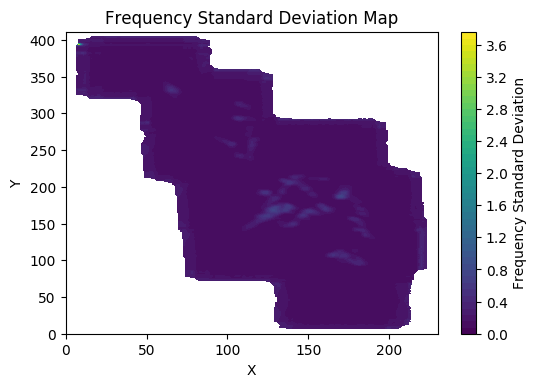

In [8]:
i = np.arange(0,231,1)
j = np.arange(0,412,1)
X,Y = np.meshgrid(i,j)
plt.figure(dpi=100)
plt.contourf(X,Y,sigma,levels=50)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Frequency Standard Deviation Map")
plt.colorbar(label="Frequency Standard Deviation",)
plt.show()

In [9]:
#Problem4
z = ma.masked_inside(sigma,0.3,1.1)

/opt/python/3.7.3/lib/python3.7/site-packages/numpy/ma/core.py:2150: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
/opt/python/3.7.3/lib/python3.7/site-packages/numpy/ma/core.py:2150: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)


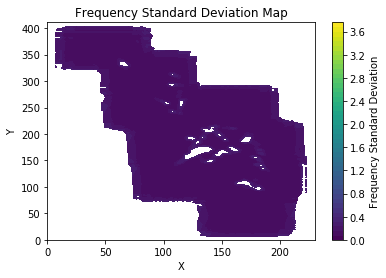

In [10]:
plt.contourf(X,Y,z,levels=50)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Frequency Standard Deviation Map")
plt.colorbar(label="Frequency Standard Deviation",)
plt.show()

mean: 0.13193213824960595
median: 0.11505924548905336


/opt/python/3.7.3/lib/python3.7/site-packages/numpy/lib/function_base.py:3523: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


'\nBoth the mean and the median seem to be fairly good representations of the overall noise level\nif we omit the emission line regions.\n'

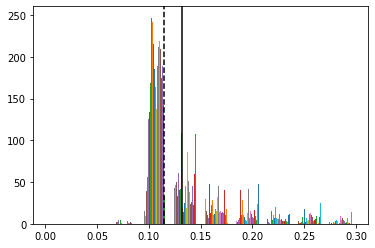

In [11]:
#Problem5
plt.hist(z,bins=10,range=(0.0,0.3))
plt.axvline(np.nanmean(z),color='k',linestyle='solid')
plt.axvline(np.nanmedian(z),color='k',linestyle='dashed')
print('mean:',np.nanmean(z))
print('median:',np.nanmedian(z))

'''
Both the mean and the median seem to be fairly good representations of the overall noise level
if we omit the emission line regions.
'''


In [12]:
#Part 2: Moment Map
#first generate a 1d array for the frequency axis
f0 = hdul[0].header['RESTFRQ']
df = hdul[0].header['CDELT3']
ref_pix = int(hdul[0].header['CRPIX3'])
pix_val = hdul[0].header['CRVAL3']

frequency = np.zeros(762)
for i in range(762):
    if i< ref_pix:
        f = pix_val-(i-ref_pix)*df
    else:
        f = pix_val+(ref_pix-i)*df
    frequency[(i)]=f

In [13]:
#define a function to convert from frequency to velocity
convert_v = lambda t: (constants.c)*(f0**2-t**2)/(f0**2+t**2)
velocity = convert_v(frequency)   

In [14]:
#velocity resolution
dv = velocity[2]-velocity[1]

In [15]:
def Moment_0(j,i):
    v = image_data[:,j,i]
    sum_A = np.nansum(v)
    M0 = dv*sum_A
    return M0

def Moment_1(j,i):
    v = image_data[:,j,i]
    sum_A = np.nansum(v)
    M1 = np.nansum(velocity*image_data[:,j,i])/sum_A
    return M1    
def Moment_2(j,i):
    v = image_data[:,j,i]
    sum_A = np.nansum(v)
    M1 = np.nansum(velocity*image_data[:,j,i])/sum_A
    M2 = np.sqrt((np.nansum(image_data[:,j,i]*(velocity-M1)**2))/sum_A)
    return M2

In [16]:
M0 = np.zeros((412,231))
for i in range(231):
    for j in range(412):
        m0 = Moment_0(j,i)
        M0[(j,i)]=m0


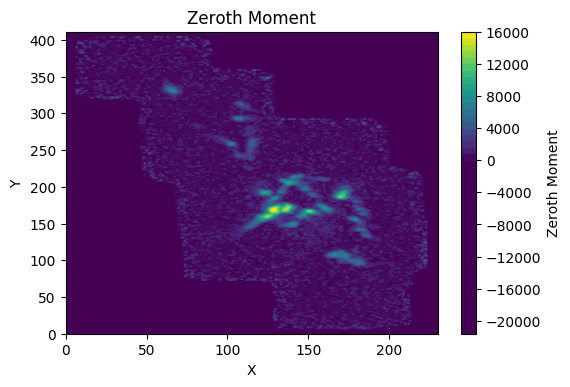

In [22]:
i = np.arange(0,231,1)
j = np.arange(0,412,1)
X,Y = np.meshgrid(i,j)
plt.figure(dpi=100)
plt.contourf(X,Y,M0,levels=50)
plt.clim(0,16000)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Zeroth Moment")
plt.colorbar(label="Zeroth Moment",)
plt.show()

In [18]:
M1 = np.zeros((412,231))
for i in range(231):
    for j in range(412):
        m1 = Moment_1(j,i)
        M1[(j,i)]= m1

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


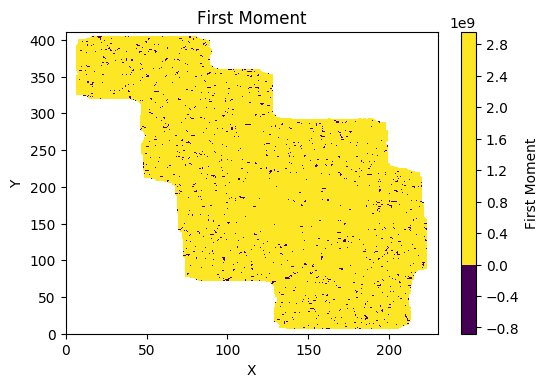

In [26]:
i = np.arange(0,231,1)
j = np.arange(0,412,1)
X,Y = np.meshgrid(i,j)
plt.figure(dpi=100)
plt.contourf(X,Y,M1,levels=50)
plt.clim(0,2.8)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("First Moment")
plt.colorbar(label="First Moment",)
plt.show()

In [20]:
M2 = np.zeros((412,231))
for i in range(231):
    for j in range(412):
        m2 = Moment_2(j,i)
        M2[(j,i)]= m2

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


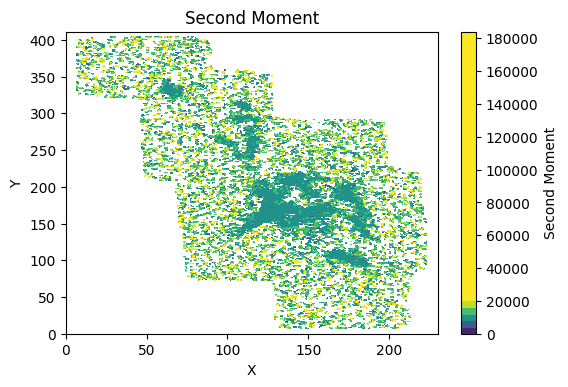

In [28]:
i = np.arange(0,231,1)
j = np.arange(0,412,1)
X,Y = np.meshgrid(i,j)
plt.figure(dpi=100)
plt.contourf(X,Y,M2,levels=50)
plt.clim(0,20000)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Second Moment")
plt.colorbar(label="Second Moment",)
plt.show()